<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter09/predicting_multiple_instances_of_multiple_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# #import os
# #os.chdir('/content/drive/MyDrive/mcvp-packt/Chapter09')

In [4]:
# import os
# if not os.path.exists('/content/drive/MyDrive/mcvp-packt/Chapter09/images.tar'):
#   !wget --quiet -O /content/drive/MyDrive/mcvp-packt/Chapter09/images.tar http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
# if not os.path.exists('/content/drive/MyDrive/mcvp-packt/Chapter09/annotations_instance.tar'):
#   !wget --quiet -O /content/drive/MyDrive/mcvp-packt/Chapter09/annotations_instance.tar http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar


In [5]:
# !tar -xf /content/drive/MyDrive/mcvp-packt/Chapter09/images.tar
# !tar -xf /content/drive/MyDrive/mcvp-packt/Chapter09/annotations_instance.tar

# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py

In [6]:
# # !pip install -qU torch_snippets
# #!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# !pip install --upgrade pycocotools

In [7]:
import torch
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

In [9]:
classes_list = [4,6]
annots = []
for ann in Tqdm(all_annots[:500]):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if np.array([num in np.unique(r) for num in classes_list]).sum()==0: continue
    annots.append(ann)
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots[:50], random_state=2)

100%|████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 91.91it/s]


In [10]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
def get_mask(path):
    an = read(path, 1).transpose(2,0,1)
    r,g,b = an
    cls = list(set(np.unique(r)).intersection({4,6}))
    print(cls)
    masks = []
    labels = []
    for _cls in cls:
      nzs = np.nonzero(r==_cls)
      instances = np.unique(g[nzs])
      for ix,_id in enumerate(instances):
          masks.append(g==_id)
          labels.append(classes_list.index(_cls)+1)
    return np.array(masks), np.array(labels)

In [12]:
print(f"train items:{len(trn_items)},valicate items:{len(val_items)}")
_id = trn_items[10]
img_path = f'images/training/{_id}.jpg'

train items:37,valicate items:13


In [13]:
#get_mask(img_path)

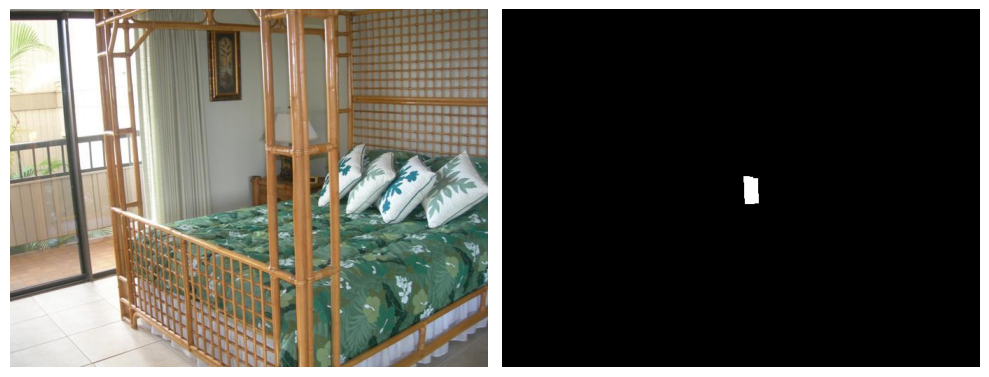

In [14]:
from torch.utils.data import Dataset
import torch
from torch_snippets.inspector import inspect
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self,path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        cls = list(set(np.unique(r)).intersection({4,6}))
        masks = []
        labels = []
        for _cls in cls:
          nzs = np.nonzero(r==_cls)
          instances = np.unique(g[nzs])
          for ix,_id in enumerate(instances):
              masks.append(g==_id)
              labels.append(classes_list.index(_cls)+1)
        return np.array(masks), np.array(labels)
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks, labels = self.get_mask(mask_path)
        #print(labels)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        image_id = ix
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8):
          img = img/255.
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[1]
#inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [15]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [16]:
model = get_model_instance_segmentation(3).to(device)

C:\Users\hunter\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hunter\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
#dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
#dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)



dataset = MasksDataset(trn_items, get_transform(train=True), N=len(trn_items))
dataset_test = MasksDataset(val_items, get_transform(train=False), N=len(val_items))


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [18]:
num_classes = 3
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [19]:
model.eval()
pred = model(dataset[0][0][None].to(device))
#inspect(pred[0])

In [20]:
num_epochs =5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

D:\open-source\mcvp-packt\Chapter09\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/19]  eta: 0:03:45  lr: 0.000282  loss: 3.0005 (3.0005)  loss_classifier: 1.1637 (1.1637)  loss_box_reg: 0.0927 (0.0927)  loss_mask: 1.6875 (1.6875)  loss_objectness: 0.0502 (0.0502)  loss_rpn_box_reg: 0.0064 (0.0064)  time: 11.8606  data: 0.0306
Epoch: [0]  [10/19]  eta: 0:02:06  lr: 0.003058  loss: 2.1057 (2.0301)  loss_classifier: 0.2549 (0.5769)  loss_box_reg: 0.1479 (0.1764)  loss_mask: 1.3197 (1.1831)  loss_objectness: 0.0396 (0.0816)  loss_rpn_box_reg: 0.0064 (0.0120)  time: 14.0413  data: 0.0388
Epoch: [0]  [18/19]  eta: 0:00:13  lr: 0.005000  loss: 1.2442 (1.5997)  loss_classifier: 0.2290 (0.4102)  loss_box_reg: 0.1479 (0.1570)  loss_mask: 0.6952 (0.9481)  loss_objectness: 0.0401 (0.0751)  loss_rpn_box_reg: 0.0051 (0.0093)  time: 13.3735  data: 0.0389
Epoch: [0] Total time: 0:04:14 (13.3736 s / it)
creating index...
index created!
Test:  [ 0/13]  eta: 0:00:48  model_time: 3.7188 (3.7188)  evaluator_time: 0.0084 (0.0084)  time: 3.7317  data: 0.0045
Test:  [12/13]

In [21]:
print(res)

In [22]:
def reload(lib):
    import sys
    keys=[]
    for k in sys.modules.keys():
        if lib in k:
            print(k)
            keys.append(k)
            
    for k in keys:
        del sys.modules[k]

In [23]:
# reload("pycocotools")
# reload("engine")
# from engine import train_one_epoch, evaluate

# res = evaluate(model, data_loader_test, device=device)

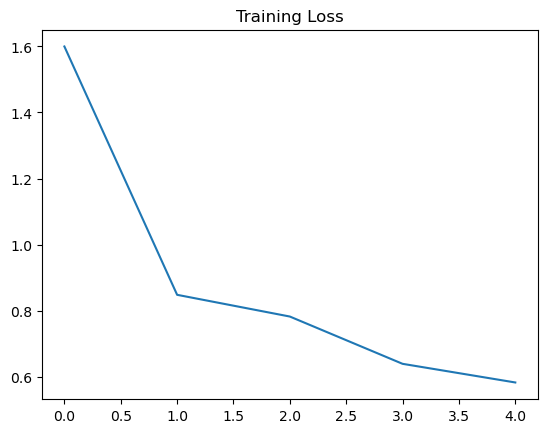

In [24]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

In [25]:
# torch.save({'model': model.state_dict()}, 'ch9-3.pth')
# ## 读取模型
# model = net()
# state_dict = torch.load('model_name.pth')
# model.load_state_dict(state_dict['model'])
# !cp ch9-3.pth  drive/MyDrive/mcvp-packt/Chapter09/

In [59]:
k=5

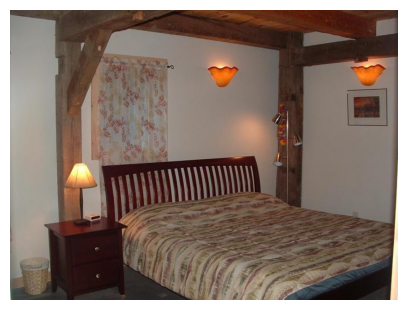

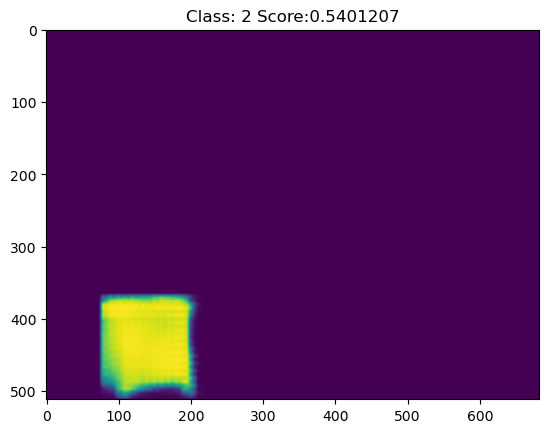

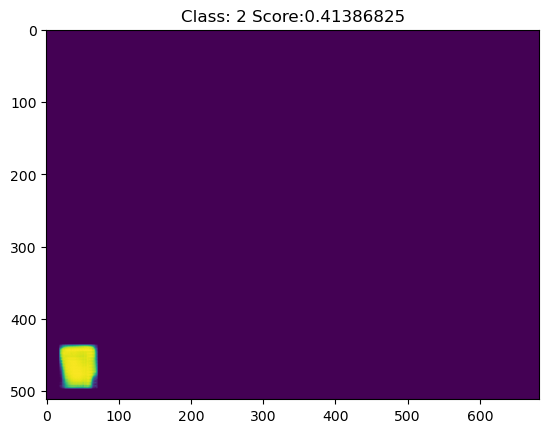

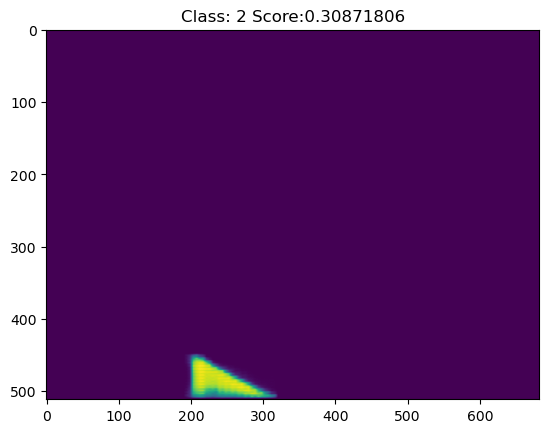

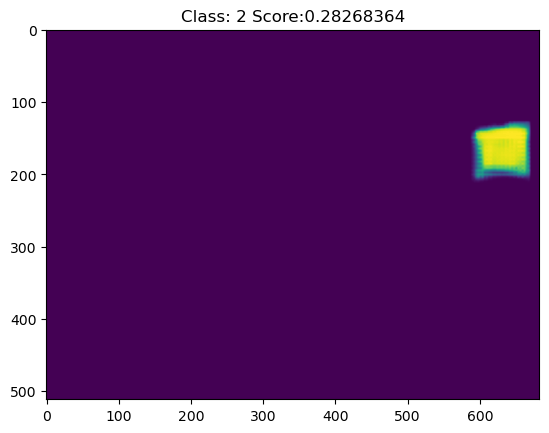

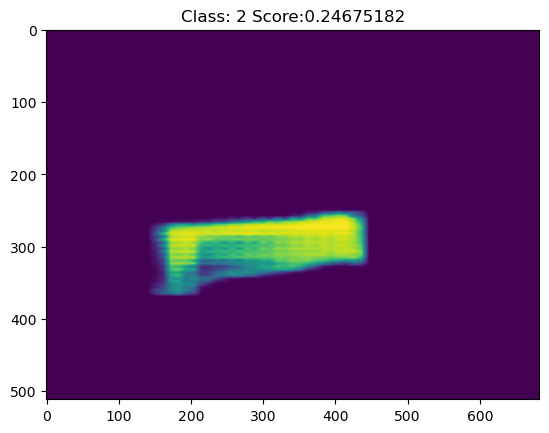

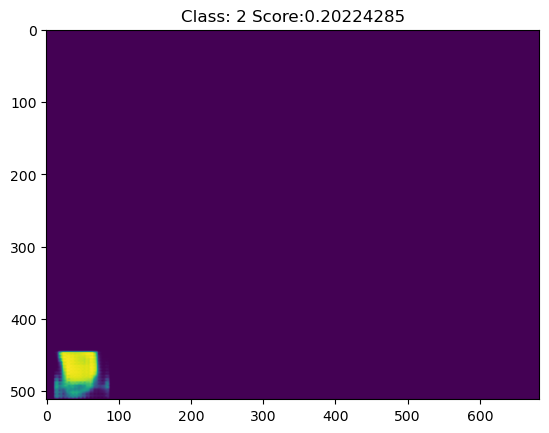

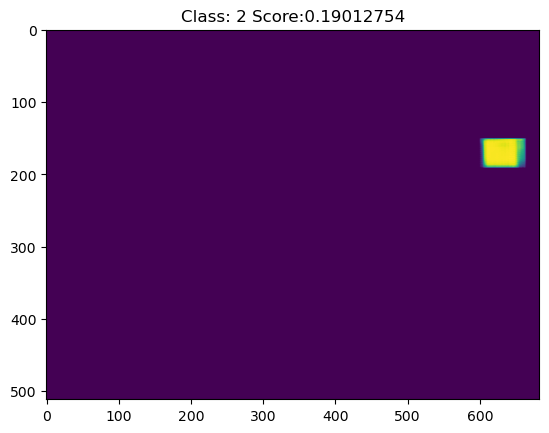

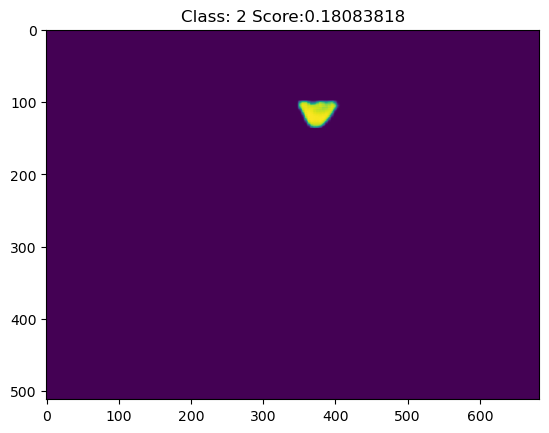

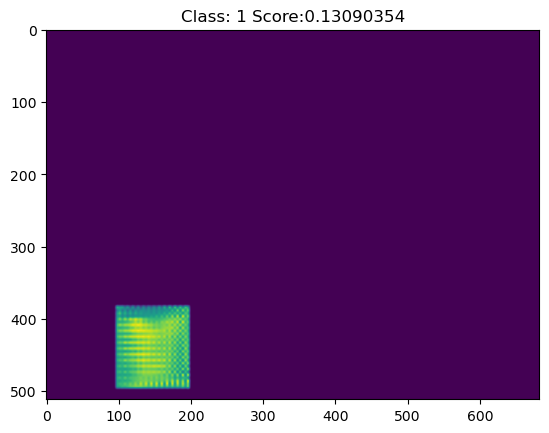

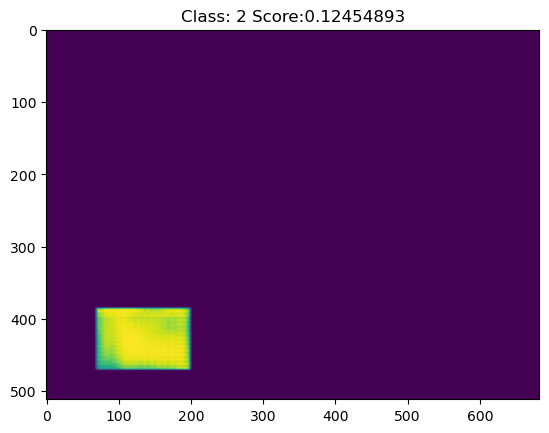

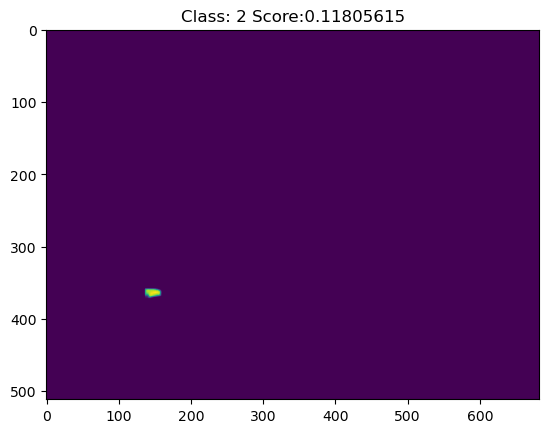

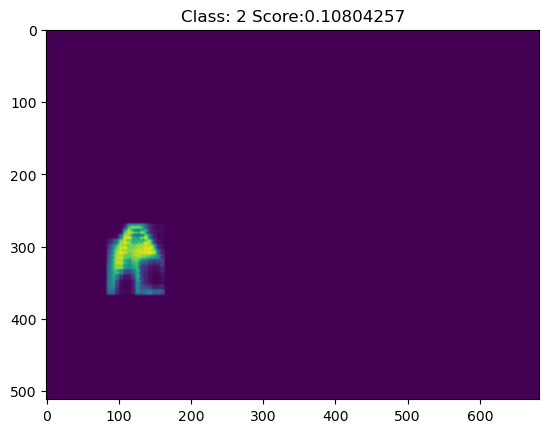

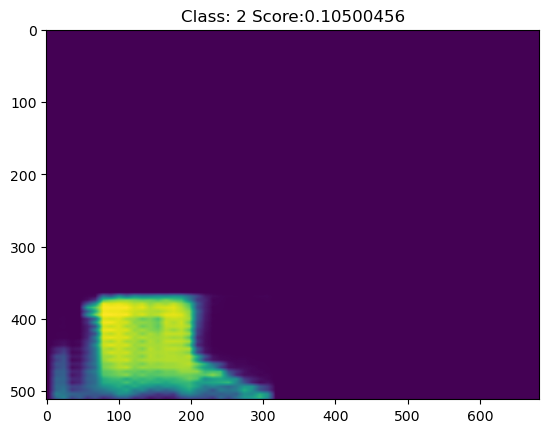

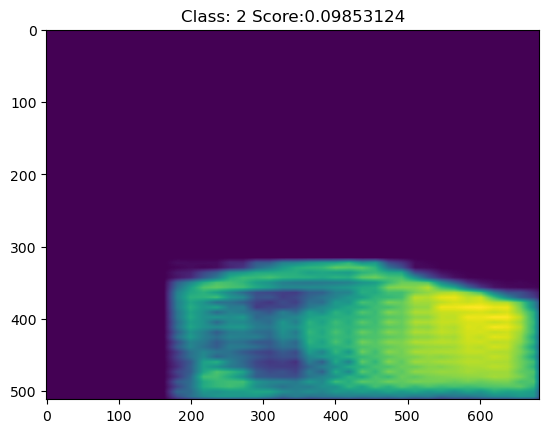

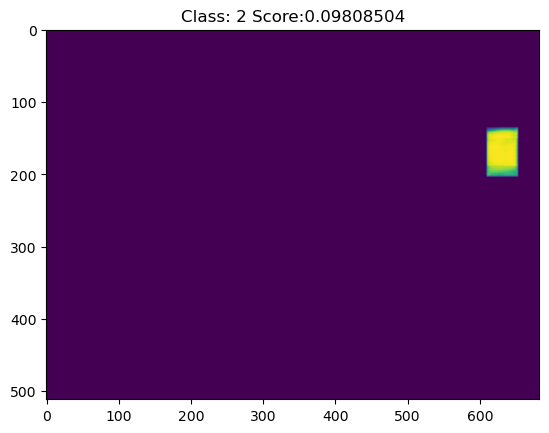

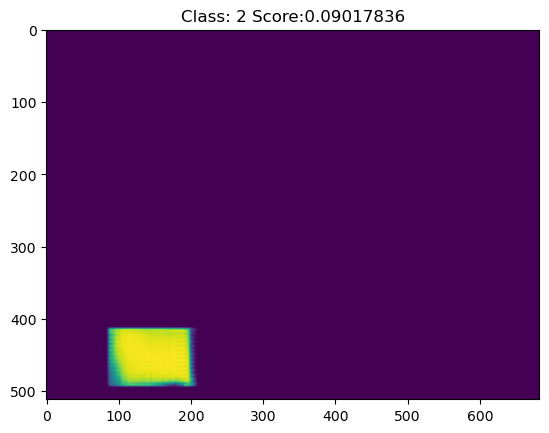

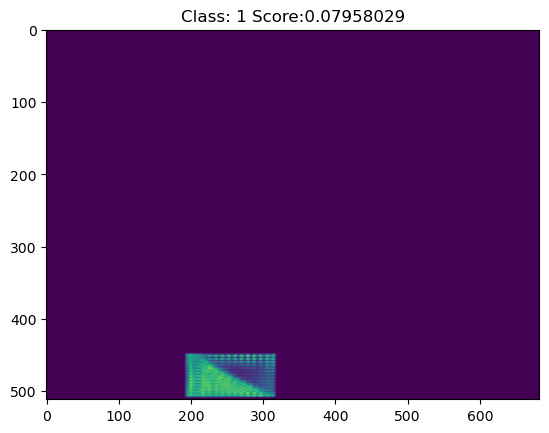

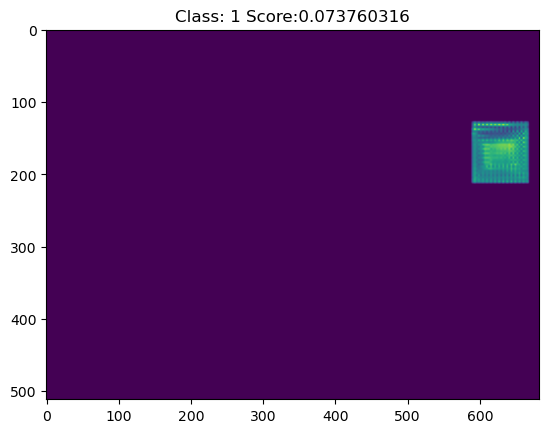

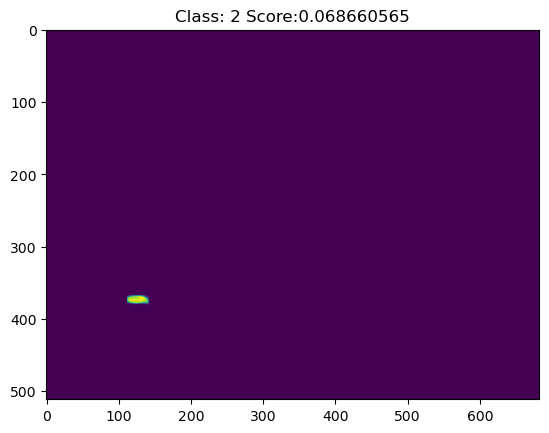

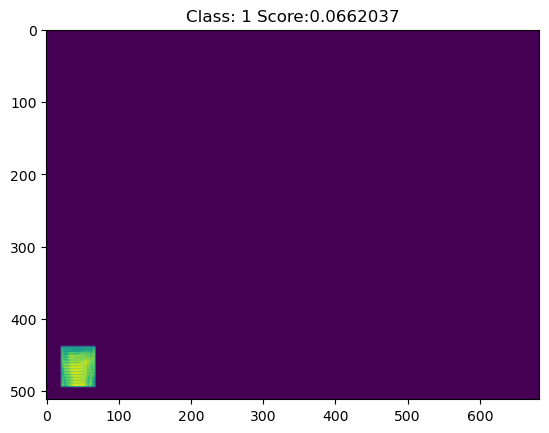

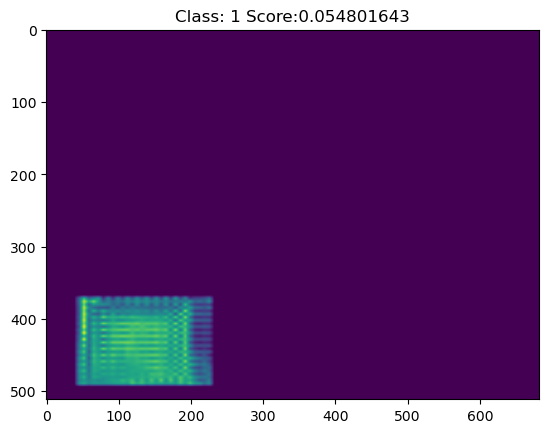

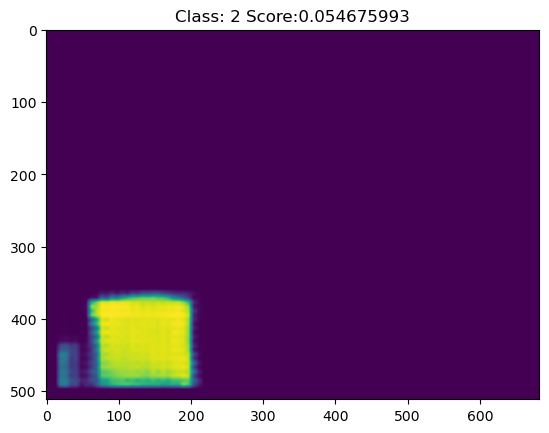

In [60]:
import matplotlib.pyplot as plt

model.eval()
k+=1
im = dataset_test[k][0]
show(im,sz=5)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()